In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2024-01-01'

data = yf.download(ticker, start=start_date, end=end_date)

data.head

[*********************100%%**********************]  1 of 1 completed


<bound method NDFrame.head of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02   74.059998   75.150002   73.797501   75.087502   72.876106   
2020-01-03   74.287498   75.144997   74.125000   74.357498   72.167618   
2020-01-06   73.447502   74.989998   73.187500   74.949997   72.742668   
2020-01-07   74.959999   75.224998   74.370003   74.597504   72.400543   
2020-01-08   74.290001   76.110001   74.290001   75.797501   73.565178   
...                ...         ...         ...         ...         ...   
2023-12-22  195.179993  195.410004  192.970001  193.600006  192.868149   
2023-12-26  193.610001  193.889999  192.830002  193.050003  192.320206   
2023-12-27  192.490005  193.500000  191.089996  193.149994  192.419830   
2023-12-28  194.139999  194.660004  193.169998  193.580002  192.848206   
2023-12-29  193.899994  194.399994  191.729996  192.529999  191.802170   

       

In [3]:
short_window = 50
long_window = 200

data['SMA50'] = data['Close'].rolling(window=short_window).mean()
data['SMA200'] = data['Close'].rolling(window=long_window).mean()

data[['Close', 'SMA50', 'SMA200']].tail()

,Close,SMA50,SMA200
Date,,,
2023-12-22,193.600006,185.398801,178.649100
2023-12-26,193.050003,185.682801,178.871851
2023-12-27,193.149994,185.971400,179.085250
2023-12-28,193.580002,186.300001,179.290201
2023-12-29,192.529999,186.633801,179.487900


In [4]:
data['Signal'] = 0

data['Signal'] = np.where(data['SMA50'] > data['SMA200'], 1, 0)

# This is another, more complicated way of doing the line above without using numpy.
# data.loc[short_window:, 'Signal'] = \
#     [1 if data['SMA50'].iloc[i] > data['SMA200'].iloc[i] else 0 for i in range(short_window, len(data))]

data['Position'] = data['Signal'].diff() # 1 for buy, -1 for sell

data.tail

<bound method NDFrame.tail of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02   74.059998   75.150002   73.797501   75.087502   72.876106   
2020-01-03   74.287498   75.144997   74.125000   74.357498   72.167618   
2020-01-06   73.447502   74.989998   73.187500   74.949997   72.742668   
2020-01-07   74.959999   75.224998   74.370003   74.597504   72.400543   
2020-01-08   74.290001   76.110001   74.290001   75.797501   73.565178   
...                ...         ...         ...         ...         ...   
2023-12-22  195.179993  195.410004  192.970001  193.600006  192.868149   
2023-12-26  193.610001  193.889999  192.830002  193.050003  192.320206   
2023-12-27  192.490005  193.500000  191.089996  193.149994  192.419830   
2023-12-28  194.139999  194.660004  193.169998  193.580002  192.848206   
2023-12-29  193.899994  194.399994  191.729996  192.529999  191.802170   

       

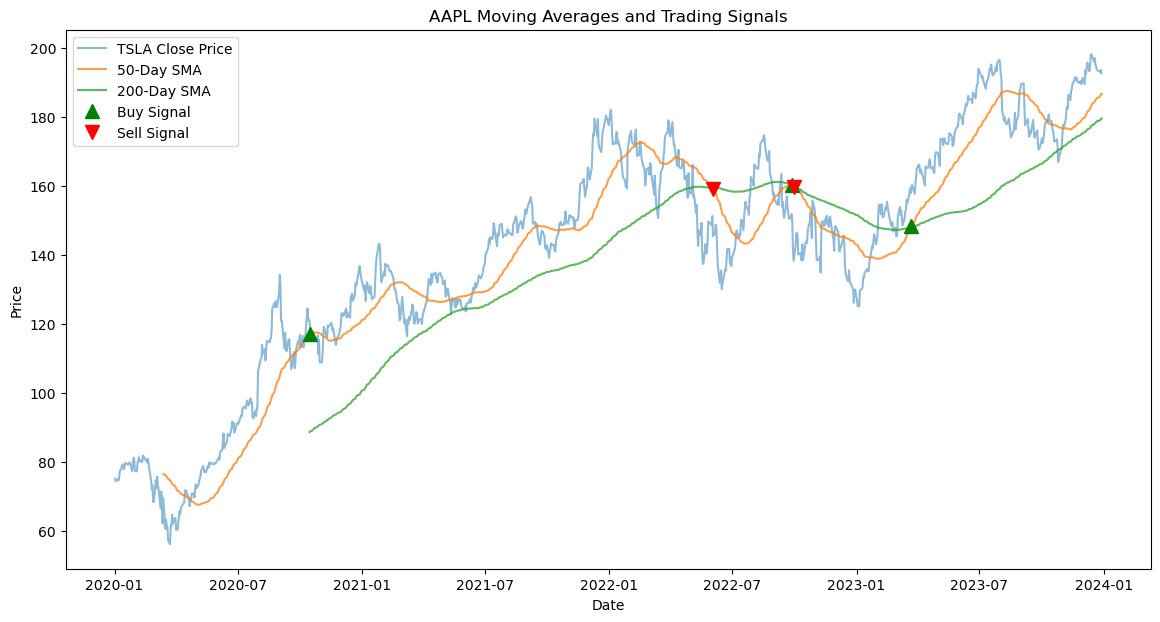

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='TSLA Close Price', alpha=0.5)
plt.plot(data['SMA50'], label='50-Day SMA', alpha=0.75)
plt.plot(data['SMA200'], label='200-Day SMA', alpha=0.75)

# Plot buy signals
plt.plot(data[data['Position'] == 1].index, 
         data['SMA50'][data['Position'] == 1], 
         '^', markersize=10, color='g', label='Buy Signal')

# Plot sell signals
plt.plot(data[data['Position'] == -1].index, 
         data['SMA50'][data['Position'] == -1], 
         'v', markersize=10, color='r', label='Sell Signal')

plt.title(f'{ticker} Moving Averages and Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [6]:
def backtest_strategy(data, initial_capital=10000, share_size=10):
    """
    Backtest the moving average crossover strategy.
    
    Parameters:
    data: pandas DataFrame containing historical stock data with 'Position' indicating buy/sell signals.
    initial_capital: Initial amount of money to start with in dollars.
    share_size: Number of shares bought/sold per trade.
    
    Returns:
    portfolio: A pandas DataFrame showing the portfolio's performance over time.
    """

    # Create a new DataFrame to track the performance
    portfolio = data[['Close']].copy()

    # Add columns for positions, cash, and portfolio value
    portfolio['Position'] = data['Position']  # buy/sell signals from strategy
    portfolio['Holdings'] = 0  # The value of the stock we own
    portfolio['Cash'] = initial_capital  # Initial capital
    portfolio['Total'] = initial_capital  # Total portfolio value

    # Variable to track the number of shares owned
    shares_owned = 0
    
    # Loop through the data to simulate buy/sell decisions
    for i in range(1, len(portfolio)):
        # If a buy signal (Position == 1)
        if portfolio['Position'][i] == 1:  
            # Buy 'share_size' worth of stock
            shares_owned += share_size
            cost = share_size * portfolio['Close'][i]
            portfolio['Cash'][i:] -= cost  # Subtract from cash
            
        # If a sell signal (Position == -1)
        elif portfolio['Position'][i] == -1 and shares_owned > 0:
            # Sell all shares
            proceeds = shares_owned * portfolio['Close'][i]
            portfolio['Cash'][i:] += proceeds  # Add to cash
            shares_owned = 0  # Reset shares_owned after selling

        # Update the holdings value for each day (close price * number of shares owned)
        portfolio['Holdings'][i] = shares_owned * portfolio['Close'][i]

        # Calculate total portfolio value (cash + stock holdings)
        portfolio['Total'][i] = portfolio['Cash'][i] + portfolio['Holdings'][i]

    return portfolio


C:\Users\eschr\AppData\Local\Temp\ipykernel_12616\2531468715.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if portfolio['Position'][i] == 1:
C:\Users\eschr\AppData\Local\Temp\ipykernel_12616\2531468715.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif portfolio['Position'][i] == -1 and shares_owned > 0:
C:\Users\eschr\AppData\Local\Temp\ipykernel_12616\2531468715.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  po

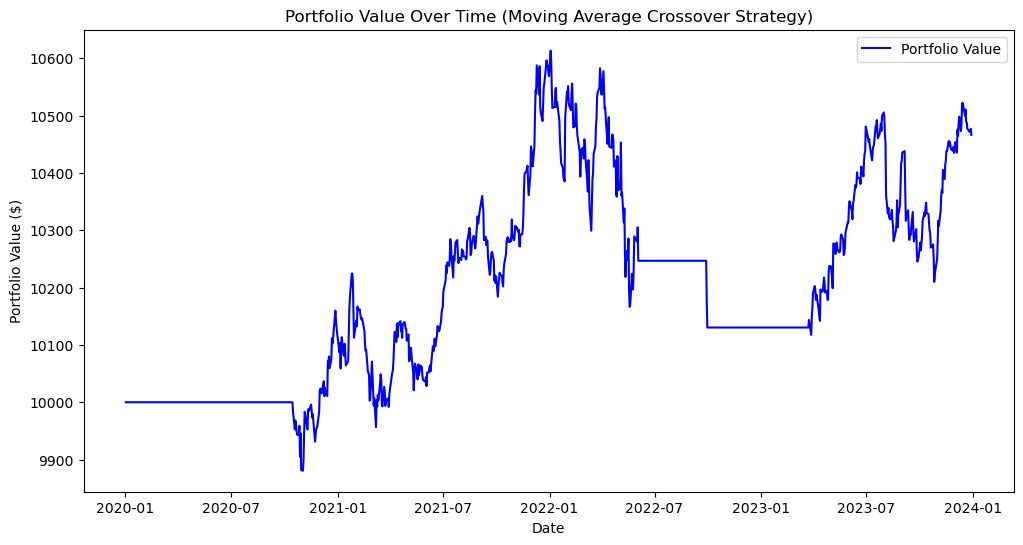

In [7]:
# Backtest the strategy with an initial capital of $10,000 and buying/selling 10 shares per trade
portfolio = backtest_strategy(data, initial_capital=10000, share_size=10)

# Plot portfolio value over time

plt.figure(figsize=(12, 6))
plt.plot(portfolio['Total'], label='Portfolio Value', color='b')
plt.title('Portfolio Value Over Time (Moving Average Crossover Strategy)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()